In [4]:
import numpy as np
import pandas as pd

In [ ]:
%pip install conect2py

In [6]:
# MODEL FUNCTIONS
from conect2py.models import TAC
from conect2py.models import AutoTAC

# RUN FUNCTIONS
from conect2py.run.single import print_run_details
from conect2py.run.multiple import run_multiple_instances, get_optimal_params, display_multirun_optimal_values, run_optimal_combination

# UTILS FUNCTIONS
from conect2py.utils.format_save import create_param_combinations, create_compressor_list, create_eval_df 
from conect2py.utils.metrics import get_compression_report, print_compression_report, calc_statistics
from conect2py.utils.plots import plot_curve_comparison, plot_dist_comparison, plot_multirun_metric_results 


In [7]:
# define the dictionary to hold the experiment results
exp_compression_report = {}
exp_statistics_report = {}

In [8]:
# read csv file
df = pd.read_csv('../gasolina_2023_concatenado.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30889 entries, 0 to 30888
Data columns (total 88 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   GPS Time                                              30889 non-null  object 
 1    Device Time                                          30889 non-null  object 
 2    Longitude                                            30889 non-null  float64
 3    Latitude                                             30889 non-null  float64
 4   GPS Speed (Meters/second)                             30889 non-null  float64
 5    Horizontal Dilution of Precision                     30889 non-null  float64
 6    Altitude                                             30889 non-null  float64
 7    Bearing                                              30889 non-null  float64
 8    G(x)                                                 30

In [9]:
print(df.columns.tolist())

['GPS Time', ' Device Time', ' Longitude', ' Latitude', 'GPS Speed (Meters/second)', ' Horizontal Dilution of Precision', ' Altitude', ' Bearing', ' G(x)', ' G(y)', ' G(z)', ' G(calibrated)', ' Absolute Throttle Position B(%)', 'Acceleration Sensor(Total)(g)', 'Acceleration Sensor(X axis)(g)', 'Acceleration Sensor(Y axis)(g)', 'Acceleration Sensor(Z axis)(g)', 'Accelerator PedalPosition D(%)', 'Accelerator PedalPosition E(%)', 'Air Fuel Ratio(Commanded)(:1)', 'Alcohol Fuel Percentage(%)', 'Android device Battery Level(%)', 'Average trip speed(whilst moving only)(km/h)', 'Average trip speed(whilst stopped or moving)(km/h)', 'Barometer (on Android device)(mb)', 'Barometric pressure (from vehicle)(psi)', 'Catalyst Temperature (Bank 1 Sensor 1)(°C)', 'Commanded Equivalence Ratio(lambda)', 'CO₂ in g/km (Average)(g/km)', 'CO₂ in g/km (Instantaneous)(g/km)', 'Distance to empty (Estimated)(km)', 'Distance travelled since codes cleared(km)', 'Distance travelled with MIL/CEL lit(km)', 'Engine Co

In [10]:
data = df['Average trip speed(whilst stopped or moving)(km/h)']

In [11]:
sensor_data = pd.DataFrame({'Time': range(1, len(data) + 1), 'Avg_trip_speed': data })


In [12]:
sensor_data.describe()

,Time,Avg_trip_speed
count,30889.000000,30889.000000
mean,15445.000000,16.734863
std,8917.030569,4.178219
min,1.000000,0.690000
25%,7723.000000,14.170000
50%,15445.000000,17.030000
75%,23167.000000,19.700000
max,30889.000000,26.090000


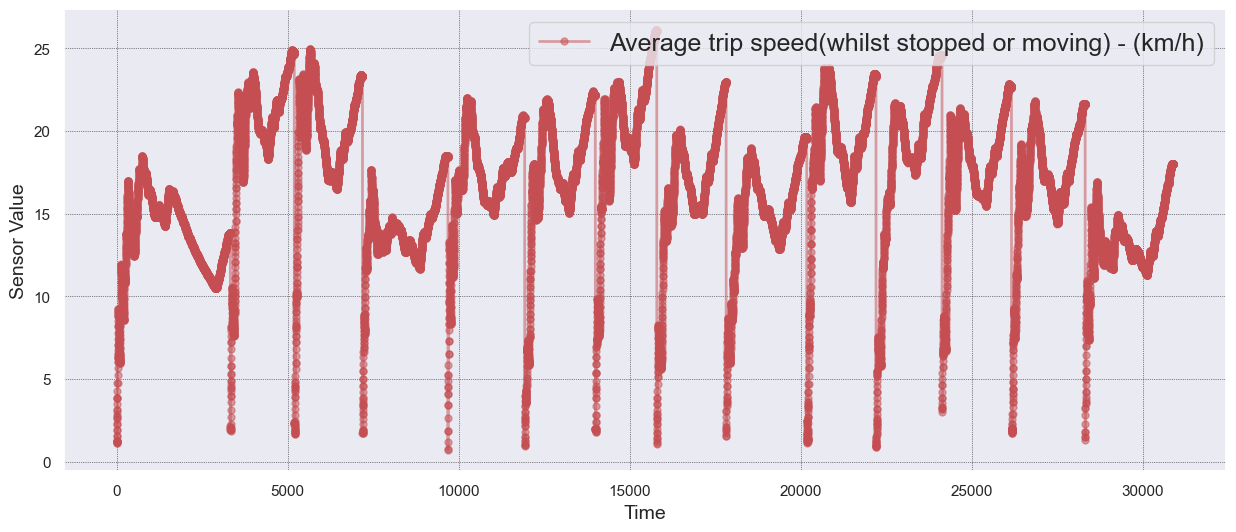

In [22]:
sns.set()
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.clear()
# define the curve1 and curve2 based on the params
curve1 = sensor_data['Avg_trip_speed']
curve1_name = 'Average trip speed(whilst stopped or moving) - (km/h)'
# plot the 2 curves
ax.plot(curve1, color='r', marker='o', linewidth=2, markersize=5, zorder=1, alpha=0.5, label=curve1_name)
#fig.suptitle('Average trip speed Visualization', fontsize=16)
ax.legend(fontsize=18, loc='upper right')
ax.set_ylabel('Sensor Value', fontsize=14)
ax.set_xlabel('Time', fontsize=14)
plt.grid(color='k', linestyle=':', linewidth=0.5)

## Running TAC


Setting up the initial variables 

In [23]:
# first create a model name (not necessary but useful for saving)
model_name = 'TAC_TripSpeed_data'

# Create the params dictionary (actually necessary)
params = {
    'window_size': np.arange(2, 30, 1),
    'm': np.round(np.arange(0.1, 2.1, 0.1), 2),
}

param_combination = create_param_combinations(params)
compressor_list = create_compressor_list(param_combination)

print(len(compressor_list), 'compressors created')

560 compressors created


Run multiples TAC tests and save the results on a dataset

In [24]:
result_df = run_multiple_instances(compressor_list=compressor_list, 
                                param_list=param_combination,
                                series_to_compress=sensor_data['Avg_trip_speed'].dropna(),
                                cf_score_beta=2
                                )

 
result_df.head(8)

,param,reduction_rate,reduction_factor,mse,rmse,nrmse,mae,psnr,ncc,cf_score
0,"(2, 0.1)",0.4507,1.8204,0.0648,0.2545,0.0609,0.0127,39.9824,0.9982,0.8031
1,"(2, 0.2)",0.4507,1.8204,0.0648,0.2545,0.0609,0.0127,39.9823,0.9982,0.8031
2,"(2, 0.3)",0.4507,1.8204,0.0648,0.2545,0.0609,0.0127,39.9823,0.9982,0.8031
3,"(2, 0.4)",0.4508,1.8209,0.0648,0.2545,0.0609,0.0127,39.9824,0.9982,0.8032
4,"(2, 0.5)",0.4511,1.8217,0.0648,0.2545,0.0609,0.0128,39.9823,0.9982,0.8033
5,"(2, 0.6)",0.4518,1.8241,0.0648,0.2545,0.0609,0.0128,39.9823,0.9982,0.8038
6,"(2, 0.7)",0.4518,1.8241,0.0648,0.2545,0.0609,0.0128,39.9823,0.9982,0.8038
7,"(2, 0.8)",0.5015,2.0060,0.4544,0.6741,0.1613,0.0407,31.5220,0.9869,0.8268


Visualize multirun results with a plot

In [25]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 560 entries, 0 to 559
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   param             560 non-null    object 
 1   reduction_rate    560 non-null    float64
 2   reduction_factor  560 non-null    float64
 3   mse               560 non-null    float64
 4   rmse              560 non-null    float64
 5   nrmse             560 non-null    float64
 6   mae               560 non-null    float64
 7   psnr              560 non-null    float64
 8   ncc               560 non-null    float64
 9   cf_score          560 non-null    float64
dtypes: float64(9), object(1)
memory usage: 48.1+ KB


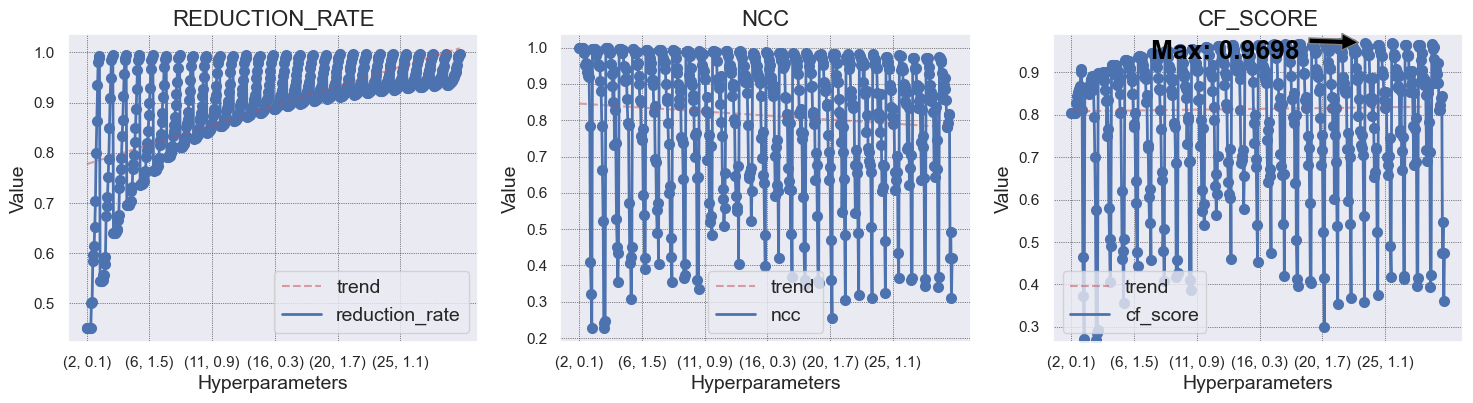

In [47]:
plot_multirun_metric_results(result_df=result_df, arrow=True, set_fontsize=14)

Visualize multirun results with dataset

In [48]:
display_multirun_optimal_values(result_df=result_df)

Parameter combinations for  MAX CF_SCORE


         param  reduction_rate  reduction_factor     mse    rmse   nrmse  \
440  (24, 0.1)          0.9224           12.8919  0.6085  0.7801  0.1867   

        mae    psnr     ncc  cf_score  
440  0.1294  30.254  0.9825    0.9698  
Parameter combinations for NEAR  MAX CF_SCORE


         param  reduction_rate  reduction_factor     mse    rmse   nrmse  \
521  (28, 0.2)          0.9336           15.0531  1.1504  1.0726  0.2567   
364  (20, 0.5)          0.9118           11.3396  0.9458  0.9725  0.2328   
262  (15, 0.3)          0.8810            8.4029  0.6337  0.7960  0.1905   
363  (20, 0.4)          0.9102           11.1352  0.9084  0.9531  0.2281   
543  (29, 0.4)          0.9372           15.9222  1.1474  1.0712  0.2564   

        mae     psnr     ncc  cf_score  
521  0.1810  27.4883  0.9666    0.9598  
364  0.1431  28.3388  0.9726    0.9598  
262  0.0907  30.0780  0.9817    0.9598  
363  0.1323  28.5140  0.9737    0.9603  
543  0.1925  2

### Running with the optimal parameters


In [49]:
optimal_param_list = get_optimal_params(result_df=result_df)
print("Best compressor param combination: ", optimal_param_list)

Best compressor param combination:  [(24, 0.1)]


In [50]:
points_to_keep, optimal_results_details = run_optimal_combination(optimal_list=optimal_param_list,
                                                          serie_to_compress=sensor_data['Avg_trip_speed'].dropna(),
                                                          model='TAC'
                                                          )

In [51]:
print_run_details(optimal_results_details)

POINTS:
 - total checked:  30889
 - total kept:  1199
 - percentage discaded:  96.12 %

POINT EVALUATION TIMES (ms): 
 - mean:  0.0035572755934563894
 - std:  0.13337439550013405
 - median:  0.0
 - max:  8.042335510253906
 - min:  0.0
 - total:  109.88068580627441

RUN TIME (ms):
 - total:  134.7511


### Evaluating the results

Set up the evaluation dataframe

In [52]:
evaluation_df = create_eval_df(original=sensor_data['Avg_trip_speed'].dropna(), flag=points_to_keep)
evaluation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30889 entries, 0 to 30888
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   original      30889 non-null  float64
 1   compressed    1199 non-null   float64
 2   decompressed  30889 non-null  float64
dtypes: float64(3)
memory usage: 724.1 KB


In [53]:
evaluation_df.head()

,original,compressed,decompressed
0,1.17,1.17,1.17000
1,1.26,NaN,1.28125
2,1.26,NaN,1.39250
3,1.22,NaN,1.50375
4,1.18,NaN,1.61500


Evaluation performance

In [54]:
# create dictionary report 
report = get_compression_report(
    original=evaluation_df['original'],
    compressed=evaluation_df['compressed'],
    decompressed=evaluation_df['decompressed'],
    cf_score_beta=2
)

print_compression_report(
    report, 
    model_name=model_name,
    cf_score_beta=2,
    model_params=optimal_param_list
)

# Save the report to a dictionary
exp_compression_report[model_name] = report


# RUN INFO #
- Model:  TAC_TripSpeed_data
- Optimal Params:  [(24, 0.1)]
- CF-Score Beta:  2

# RESULTS #

SAMPLES NUMBER reduction
- Original length:  30889  samples
- Reduced length:  1199  samples
- Samples reduced by a factor of 25.76 times
- Sample reduction rate: 96.12%

FILE SIZE compression
- Original size:  385549  Bytes
- Compressed size:  14974  Bytes
- file compressed by a factor of 25.75 times
- file compression rate: 96.12%

METRICS
- MSE:  0.622
- RMSE:  0.7886
- NRMSE:  0.1888
- MAE:  0.1384
- PSNR:  30.1591
- NCC:  0.9821
- CF-Score:  0.9778


In [55]:
model_stats = calc_statistics(evaluation_df)

# save the statistics to a dictionary
exp_statistics_report[model_name] = model_stats
model_stats

,min,max,mean,median,std,skewness,kurtosis
original,0.69,26.09,16.734863,17.030000,4.178219,-0.632882,0.796365
decompressed,1.11,26.08,16.722576,17.023077,4.088868,-0.538119,0.438040


### Creating the model visualizations

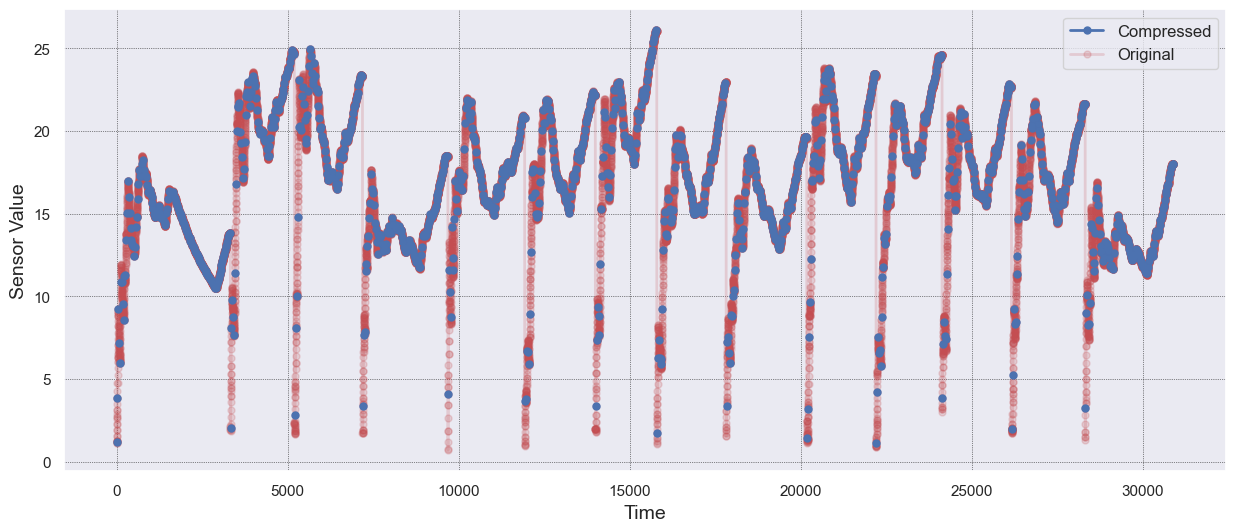

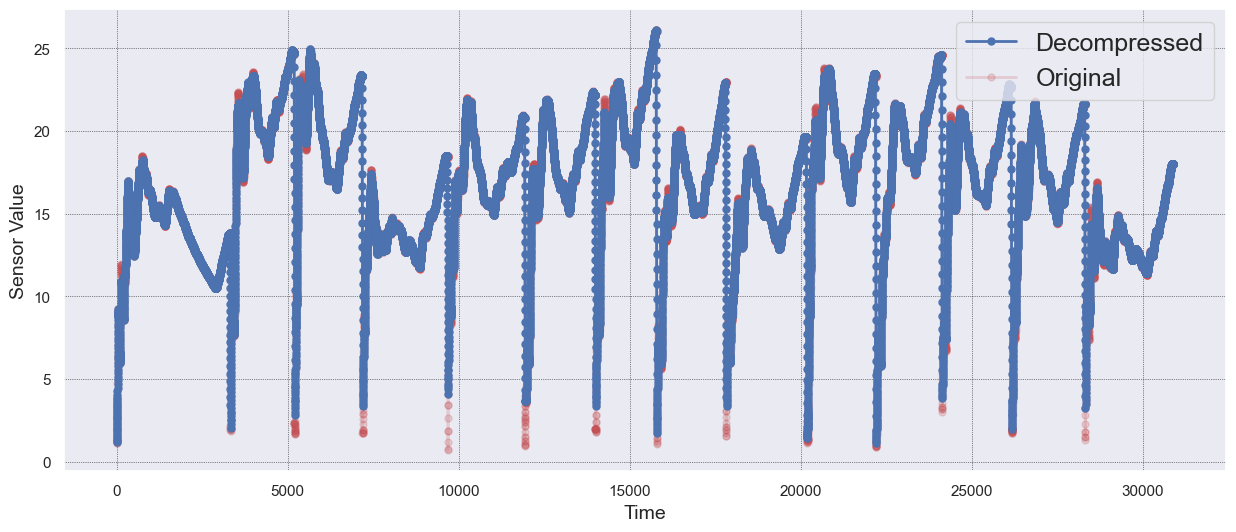

In [60]:
# plot the curves comparison (original vs compressed)
plot_curve_comparison(
    evaluation_df.original,
    evaluation_df.compressed,
    show=True
)


# plot the curves comparison (original vs decompressed)
plot_curve_comparison(
    evaluation_df.original,
    evaluation_df.decompressed,
    show=True,
    set_fontsize=18,
    loc='upper right'
)

c:\Users\Miguel\Documents\UFRN - PESQUISA\LIB-TAC\tac_lib\src\tac\utils\plots.py:88: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(reference, label=reference_name, ax=ax[0])
c:\Users\Miguel\Documents\UFRN - PESQUISA\LIB-TAC\tac_lib\src\tac\utils\plots.py:89: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.

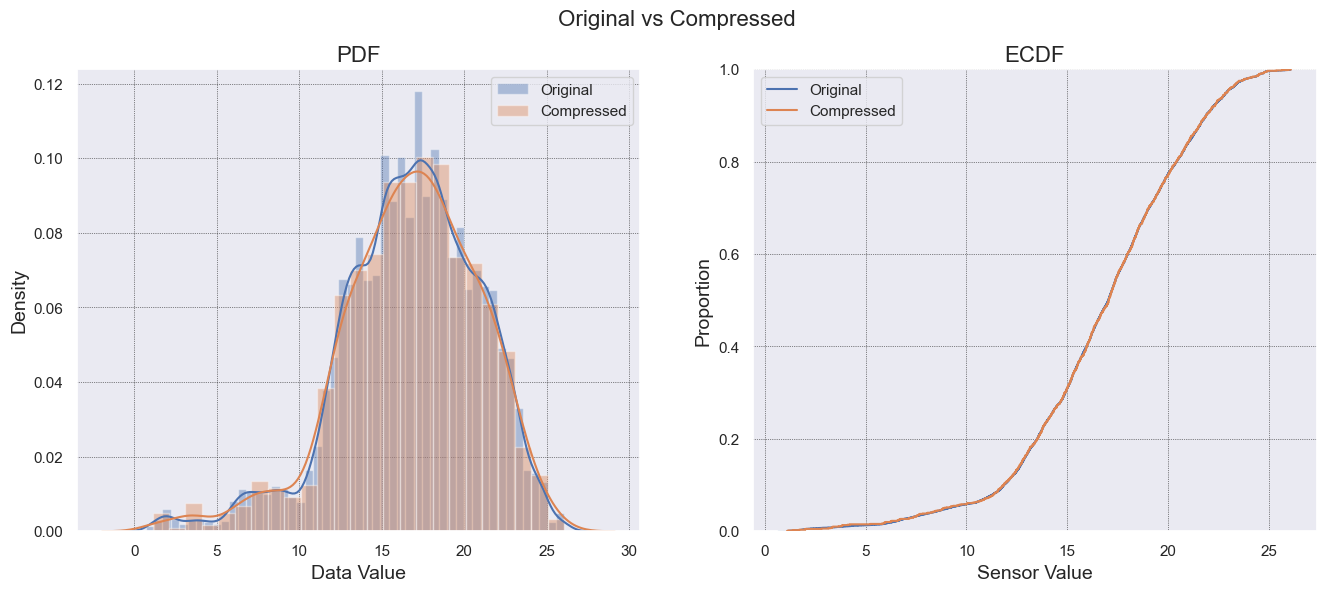

c:\Users\Miguel\Documents\UFRN - PESQUISA\LIB-TAC\tac_lib\src\tac\utils\plots.py:88: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(reference, label=reference_name, ax=ax[0])
c:\Users\Miguel\Documents\UFRN - PESQUISA\LIB-TAC\tac_lib\src\tac\utils\plots.py:89: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.

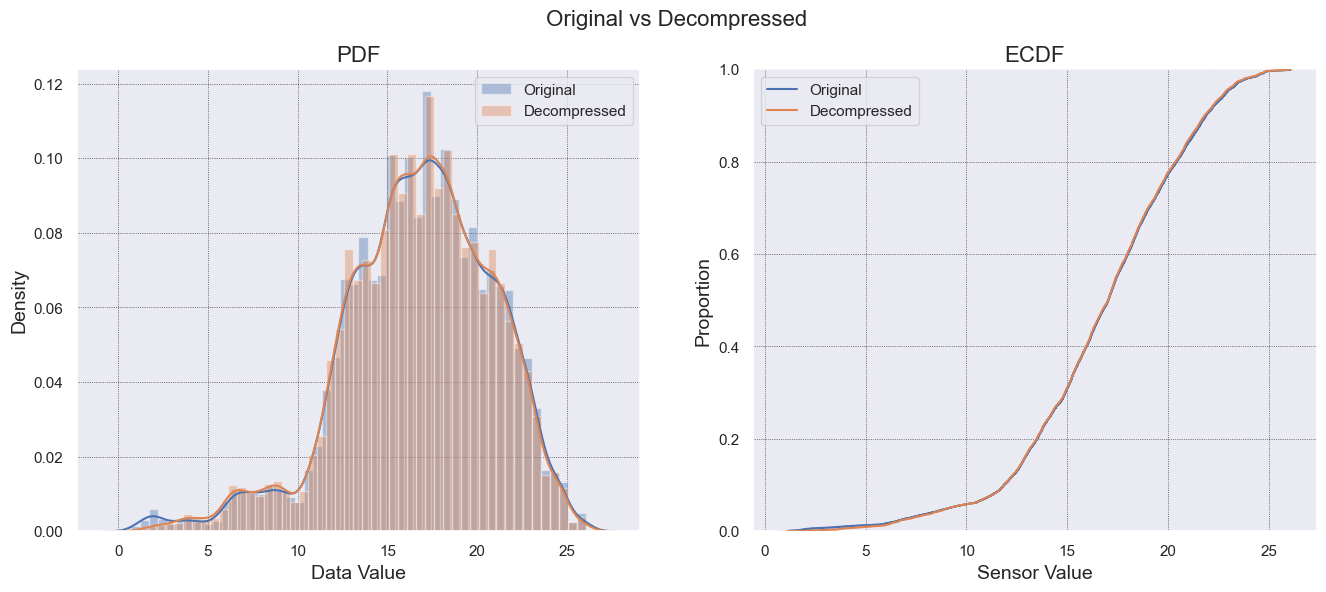

In [82]:
#compressed_dist_path = f'./results/{exp_number}/cf{exp_beta}_run/{model_name}__DIST_orig-v-comp.png'
#decompressed_dist_path = f'./results/{exp_number}/cf{exp_beta}_run/{model_name}__DIST_orig-v-decomp.png'

plot_dist_comparison(
    evaluation_df.original,
    evaluation_df.compressed,
    show=True
)
plot_dist_comparison(
    evaluation_df.original,
    evaluation_df.decompressed,
    show=True
)